In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# initializing

## load data

In [2]:
# Load in the data 
cifar100 = tf.keras.datasets.cifar100 
  
# Distribute it to train and test set 
(x_train, y_train), (x_val, y_val) = cifar100.load_data() 
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape) 

#scale the data
x_train = x_train/255
x_val = x_val/255


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [3]:
def show_samples(data, labels): 
	plt.subplots(figsize=(10, 10)) 
	for i in range(12): 
		plt.subplot(3, 4, i+1) 
		k = np.random.randint(0, data.shape[0]) 
		plt.title(labels[k]) 
		plt.imshow(data[k]) 
	plt.tight_layout() 
	plt.show() 



def show_results(hist,mode='acc'):
    if mode == 'acc' or mode == 'accuracy':
        mode = 'accuracy'
        val_mode = 'val_accuracy'
    elif mode == 'loss':
        mode = "loss"
        val_mode = "val_loss"
    
    fig = plt.figure()
    plt.plot(hist.history[mode], color='teal', label=mode)
    plt.plot(hist.history[val_mode], color='orange', label=val_mode)
    fig.suptitle(mode, fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

def prediction_test(model,x_val,y_true,show_confusion_matrix=True):
    y_hat = model.predict(x_val)
    y_pred = np.argmax(y_hat, axis=1)

    precision_micro = precision_score(y_true, y_pred, average='micro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_micro = recall_score(y_true, y_pred, average='micro')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    if show_confusion_matrix == True:
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
    print(f"precision weighted: {'{:.3f}'.format(precision_weighted)}\nprecision micro: {precision_micro} ")
    print(f'recall weighted: {recall_weighted}\nrecall micro: {recall_micro} ')
    print(f'f1 weighted: {"{:.3f}".format(f1_weighted)}\nf1 micro: {f1_micro} ')

# Build Model

In [4]:
class_count = y_train.max() + 1
input_shape = x_train[0].shape
BATCH_SIZE = 64
EPOCHS = 25
print(f'number of classes: {class_count} ')
print(f"input shape : {input_shape}")

number of classes: 100 
input shape : (32, 32, 3)


In [5]:
regulizerL2 = tf.keras.regularizers.L2(0.001)

In [6]:
model = tf.keras.models.Sequential([ 
    
	Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'), 
    Conv2D(64,(3,3), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2),strides=(2,2)),
    BatchNormalization(),
    Dropout(0.3),
    
	Conv2D(128, (3, 3), activation='relu', padding='same'), 
    Conv2D(128, (3, 3), activation='relu', padding='same'),
	MaxPooling2D(2, 2),
    BatchNormalization(),
    Dropout(0.5),
    
	Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),

    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.5),

    

	Flatten(), 
	Dense(2048, activation='relu',kernel_regularizer=regulizerL2,bias_regularizer=regulizerL2), 
    Dropout(0.4),
	BatchNormalization(), 
	Dense(2048, activation='relu',kernel_regularizer=regulizerL2), 
	Dropout(0.3), 
	BatchNormalization(), 
	Dense(class_count, activation='softmax') 
]) 
callback = EarlyStopping(monitor='val_loss',patience=4,verbose=1)

model.compile( 
	loss=tf.losses.SparseCategoricalCrossentropy(), 
	optimizer='adam',
	metrics=['accuracy'] ,
) 


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       1

In [ ]:
hist = model.fit(x_train,y_train,
                 batch_size=BATCH_SIZE, epochs=EPOCHS,
                 validation_data=(x_val,y_val),
                callbacks=[callback])


Epoch 1/25
782/782 [==============================] - 46s 52ms/step - loss: 6.8625 - accuracy: 0.0265 - val_loss: 5.7411 - val_accuracy: 0.0295
Epoch 2/25
782/782 [==============================] - 40s 51ms/step - loss: 5.6148 - accuracy: 0.0320 - val_loss: 7.7168 - val_accuracy: 0.0244
Epoch 3/25
782/782 [==============================] - 40s 51ms/step - loss: 5.2274 - accuracy: 0.0367 - val_loss: 5.9414 - val_accuracy: 0.0340
Epoch 4/25
782/782 [==============================] - 40s 51ms/step - loss: 5.0035 - accuracy: 0.0454 - val_loss: 4.7439 - val_accuracy: 0.0482
Epoch 5/25
782/782 [==============================] - 40s 51ms/step - loss: 4.8541 - accuracy: 0.0541 - val_loss: 4.6297 - val_accuracy: 0.0606
Epoch 6/25
782/782 [==============================] - 40s 51ms/step - loss: 4.6603 - accuracy: 0.0600 - val_loss: 4.4675 - val_accuracy: 0.0662
Epoch 7/25
782/782 [==============================] - 40s 51ms/step - loss: 4.5053 - accuracy: 0.0690 - val_loss: 4.4538 - val_accuracy:

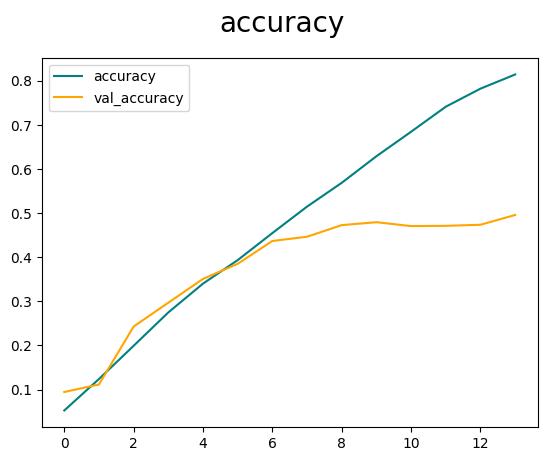

In [11]:
show_results(hist,'acc')

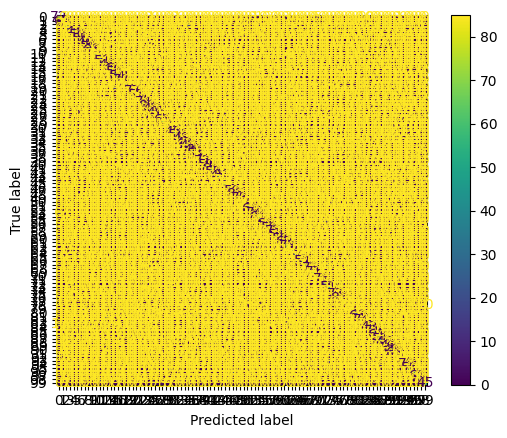

precision weighted: 0.514
precision micro: 0.5044 
recall weighted: 0.5044
recall micro: 0.5044 
f1 weighted: 0.498
f1 micro: 0.5044 


In [9]:
prediction_test(model,x_val,y_val,show_confusion_matrix=True)